In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

#### 파일 경로 load

In [2]:
PATH_TRAIN_NOTDROWSY_LIST = os.listdir("pose/train/notdrowsy/")
PATH_TRAIN_DROWSY_LIST  = os.listdir("pose/train/drowsy/")

#### MediaPipe로는?
* 눈이랑 코는 잘 나오는 듯???
* 어깨의 중심을 목으로 가정하고 하는 것이 더 편할 것 같음.
* 테스트 코드

In [3]:
import mediapipe as mp
import numpy as np
import math

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [5]:
landmark_names = [
        'nose',
        'left_eye_inner',
        'left_eye',
        'left_eye_outer',
        'right_eye_inner',
        'right_eye',
        'right_eye_outer',
        'left_ear',
        'right_ear',
        'mouth_left',
        'mouth_right',
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

#### 데이터 프레임 생성
* 사용할 Point는 코, 입, 눈 정도가 되겠다.
* 사실 코만 해도 될 것 같긴 하다.

In [9]:
def Point_by_MediaPipe(image_path, train_test, label):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    if train_test == "train":
        train_test = "train/"
    else:
        train_test = "test/"
    
    if label == "drowsy":
        label = "drowsy/"
    else:
        label = "notdrowsy/"
        
# For static images:
    IMAGE_FILES = image_path
    results = []
    BG_COLOR = (192, 192, 192) # gray
    with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        min_detection_confidence=0.5) as pose:
        for idx, file in enumerate(IMAGE_FILES):
            file = "pose/" + train_test + label + file
            image = cv2.imread(file)
            
            if image
            image_height, image_width, _ = image.shape
            
            
            results.append(pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
                
            if not results[idx].pose_landmarks:
                continue
                
            if idx % 10 == 0:
                print("전체 이미지 : %d / 완료한 이미지 %d" % (len(IMAGE_FILES), idx))
                
    print("---완료---")
    return results, image_height, image_width
            

    
    


        

#### 확인해보기

In [32]:
drowsy_results, image_height, image_width = Point_by_MediaPipe(PATH_TRAIN_DROWSY_LIST, "train", "drowsy")
notdrowsy_results, image_height, image_width = Point_by_MediaPipe(PATH_TRAIN_NOTDROWSY_LIST, "train", "notdrowsy")

전체 이미지 : 600 / 완료한 이미지 0
전체 이미지 : 600 / 완료한 이미지 10
전체 이미지 : 600 / 완료한 이미지 20
전체 이미지 : 600 / 완료한 이미지 30
전체 이미지 : 600 / 완료한 이미지 40
전체 이미지 : 600 / 완료한 이미지 50
전체 이미지 : 600 / 완료한 이미지 60
전체 이미지 : 600 / 완료한 이미지 70
전체 이미지 : 600 / 완료한 이미지 80
전체 이미지 : 600 / 완료한 이미지 90
전체 이미지 : 600 / 완료한 이미지 110
전체 이미지 : 600 / 완료한 이미지 120
전체 이미지 : 600 / 완료한 이미지 130
전체 이미지 : 600 / 완료한 이미지 140
전체 이미지 : 600 / 완료한 이미지 150
전체 이미지 : 600 / 완료한 이미지 160
전체 이미지 : 600 / 완료한 이미지 170
전체 이미지 : 600 / 완료한 이미지 180
전체 이미지 : 600 / 완료한 이미지 190
전체 이미지 : 600 / 완료한 이미지 200
전체 이미지 : 600 / 완료한 이미지 210
전체 이미지 : 600 / 완료한 이미지 220
전체 이미지 : 600 / 완료한 이미지 230
전체 이미지 : 600 / 완료한 이미지 240
전체 이미지 : 600 / 완료한 이미지 250
전체 이미지 : 600 / 완료한 이미지 260
전체 이미지 : 600 / 완료한 이미지 270
전체 이미지 : 600 / 완료한 이미지 280
전체 이미지 : 600 / 완료한 이미지 290
전체 이미지 : 600 / 완료한 이미지 300
전체 이미지 : 600 / 완료한 이미지 310
전체 이미지 : 600 / 완료한 이미지 320
전체 이미지 : 600 / 완료한 이미지 330
전체 이미지 : 600 / 완료한 이미지 340
전체 이미지 : 600 / 완료한 이미지 350
전체 이미지 : 600 / 완료한 이미지 360
전체 이미지 : 600 / 완료한 이미지 370
전체 이미지 : 600

In [33]:
len(drowsy_results)

600

In [34]:
len(notdrowsy_results)

646

#### 어깨 위치 추출

In [61]:
def Shoulder_Point(result, image_width, image_height) :
    if result.pose_landmarks != None:
        L_Shoulder_X = result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width
        R_Shoulder_X = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width
        R_Shoulder_Y = result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height
        L_Shoulder_Y = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_height
    
    else:
        R_Shoulder_X, R_Shoulder_Y,L_Shoulder_X, L_Shoulder_Y = None, None, None, None
        
    return R_Shoulder_X, R_Shoulder_Y,L_Shoulder_X, L_Shoulder_Y

#### 목 위치 계산
* 잘 나온다!

In [62]:
def Compute_Neck(result, image_width, image_height) :
    R_Shoulder_X, R_Shoulder_Y,L_Shoulder_X, L_Shoulder_Y = Shoulder_Point(result, image_width, image_height)
    try:
        Neck_X = (L_Shoulder_X + R_Shoulder_X) / float(2.0)
        Neck_Y = (L_Shoulder_Y + R_Shoulder_Y) / float(2.0)
        
    except:
        return None, None
    return Neck_X, Neck_Y

#### 코 위치 추출

In [63]:
def Nose_Point(result, image_width, image_height) :
    
    if result.pose_landmarks != None:
        Nose_X = result.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width
        Nose_Y = result.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height
        
    else:
        return None, None

    return Nose_X, Nose_Y

#### data frame 만들기
* null값 없이 잘 만들어 졌음

In [64]:
def Point_DataFrame(results, label):
    point_list = []
    if label == 0 or label == "notdrowsy":
        label = 0
    elif label == 1 or label == "drowsy":
        label = 1
    else:
        label = -1
    for result in results:
        temp = []
        Neck_X, Neck_Y = Compute_Neck(result, image_width, image_height)
        Nose_X, Nose_Y = Nose_Point(result, image_width, image_height)
        R_Shoulder_X, R_Shoulder_Y,L_Shoulder_X, L_Shoulder_Y = Shoulder_Point(result, image_width, image_height)
        temp.append(Neck_X)
        temp.append(Neck_Y)
        temp.append(Nose_X)
        temp.append(Nose_Y)
        temp.append(R_Shoulder_X)
        temp.append(R_Shoulder_Y)
        temp.append(L_Shoulder_X)
        temp.append(L_Shoulder_Y)
        temp.append(label)
        point_list.append(temp)
    dataframe = pd.DataFrame(columns = ["Neck_X", "Neck_Y", "Nose_X", "Nose_Y", "R_Shoulder_X", "R_Shoulder_Y","L_Shoulder_X", "L_Shoulder_Y", "label"],
                 data = point_list)
    return dataframe
    
        
        
    

In [65]:
train_data_drowsy = Point_DataFrame(drowsy_results, "drowsy")
train_data_notdrowsy = Point_DataFrame(notdrowsy_results, "notdrowsy")

In [66]:
train_data_drowsy

,Neck_X,Neck_Y,Nose_X,Nose_Y,R_Shoulder_X,R_Shoulder_Y,L_Shoulder_X,L_Shoulder_Y,label
0,412.136726,503.129883,471.481667,386.897564,234.190216,518.946018,590.083237,487.313747,1
1,287.026033,491.896133,230.067596,366.897011,101.206989,481.496372,472.845078,502.295895,1
2,303.095579,490.596714,241.814785,420.734396,124.803524,482.446060,481.387634,498.747368,1
3,349.210939,481.176624,388.900490,343.496876,141.069813,487.684422,557.352066,474.668827,1
4,346.343117,487.492905,308.376198,286.864758,134.417267,476.788387,558.268967,498.197422,1
...,...,...,...,...,...,...,...,...,...
595,326.053953,415.101142,392.638626,282.926044,174.036198,425.368338,478.071709,404.833946,1
596,330.534248,414.343772,385.325432,282.527332,178.158302,430.774956,482.910194,397.912588,1
597,331.800890,414.380236,380.240211,289.380169,177.308826,429.571581,486.292953,399.188890,1
598,326.532097,416.433663,386.659241,285.661068,170.135574,431.428270,482.928619,401.439056,1


In [67]:
train_data_notdrowsy

,Neck_X,Neck_Y,Nose_X,Nose_Y,R_Shoulder_X,R_Shoulder_Y,L_Shoulder_X,L_Shoulder_Y,label
0,399.811516,521.576643,405.992203,369.489040,241.046906,532.204971,558.576126,510.948315,0
1,401.286602,518.329697,405.267906,372.382050,244.032669,530.352859,558.540535,506.306534,0
2,318.899708,509.957085,344.569664,349.405346,171.893883,514.582558,465.905533,505.331612,0
3,323.547859,517.167778,357.341728,365.329113,164.257355,526.048279,482.838364,508.287277,0
4,348.046894,517.642679,385.203438,369.922228,200.691032,537.479610,495.402756,497.805748,0
...,...,...,...,...,...,...,...,...,...
641,357.191725,376.415019,377.770653,167.713566,168.191051,377.233629,546.192398,375.596409,0
642,357.626514,371.946716,357.205620,172.447300,170.391998,372.863159,544.861031,371.030273,0
643,353.261642,371.105089,340.752983,164.272556,167.403412,371.321468,539.119873,370.888710,0
644,352.953997,376.032057,350.864410,166.409054,161.153736,374.832401,544.754257,377.231712,0


In [68]:
train_data_drowsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neck_X        592 non-null    float64
 1   Neck_Y        592 non-null    float64
 2   Nose_X        592 non-null    float64
 3   Nose_Y        592 non-null    float64
 4   R_Shoulder_X  592 non-null    float64
 5   R_Shoulder_Y  592 non-null    float64
 6   L_Shoulder_X  592 non-null    float64
 7   L_Shoulder_Y  592 non-null    float64
 8   label         600 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 42.3 KB


In [69]:
train_data_notdrowsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neck_X        645 non-null    float64
 1   Neck_Y        645 non-null    float64
 2   Nose_X        645 non-null    float64
 3   Nose_Y        645 non-null    float64
 4   R_Shoulder_X  645 non-null    float64
 5   R_Shoulder_Y  645 non-null    float64
 6   L_Shoulder_X  645 non-null    float64
 7   L_Shoulder_Y  645 non-null    float64
 8   label         646 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 45.5 KB


#### Null값 제거

In [72]:
train_data_drowsy = train_data_drowsy.dropna()
train_data_notdrowsy = train_data_notdrowsy.dropna()

In [73]:
train_data_drowsy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592 entries, 0 to 599
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neck_X        592 non-null    float64
 1   Neck_Y        592 non-null    float64
 2   Nose_X        592 non-null    float64
 3   Nose_Y        592 non-null    float64
 4   R_Shoulder_X  592 non-null    float64
 5   R_Shoulder_Y  592 non-null    float64
 6   L_Shoulder_X  592 non-null    float64
 7   L_Shoulder_Y  592 non-null    float64
 8   label         592 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 46.2 KB


In [74]:
train_data_notdrowsy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645 entries, 0 to 645
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neck_X        645 non-null    float64
 1   Neck_Y        645 non-null    float64
 2   Nose_X        645 non-null    float64
 3   Nose_Y        645 non-null    float64
 4   R_Shoulder_X  645 non-null    float64
 5   R_Shoulder_Y  645 non-null    float64
 6   L_Shoulder_X  645 non-null    float64
 7   L_Shoulder_Y  645 non-null    float64
 8   label         645 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 50.4 KB


#### 코 위치와 목 위치의 차이

In [89]:
def Compute_Diff(dataframe):
    dataframe["Diff_X"] = pd.Series(dataframe.loc[:, "Neck_X"] - dataframe.loc[:, "Nose_X"])
    dataframe["Diff_Y"] = pd.Series(dataframe.loc[:, "Neck_Y"] - dataframe.loc[:, "Nose_Y"])
    return dataframe

In [90]:
train_data_drowsy = Compute_Diff(train_data_drowsy)
train_data_notdrowsy = Compute_Diff(train_data_notdrowsy)

<ipython-input-89-820a28a9058d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Diff_X"] = pd.Series(dataframe.loc[:, "Neck_X"] - dataframe.loc[:, "Nose_X"])
<ipython-input-89-820a28a9058d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Diff_Y"] = pd.Series(dataframe.loc[:, "Neck_Y"] - dataframe.loc[:, "Nose_Y"])


In [92]:
train_data_drowsy

,degree,Neck_X,Neck_Y,Nose_X,Nose_Y,R_Shoulder_X,R_Shoulder_Y,L_Shoulder_X,L_Shoulder_Y,label,Diff_X,Diff_Y
0,26.054119,412.136726,503.129883,471.481667,386.897564,234.190216,518.946018,590.083237,487.313747,1,-59.344940,116.232319
1,23.757774,287.026033,491.896133,230.067596,366.897011,101.206989,481.496372,472.845078,502.295895,1,56.958437,124.999123
2,37.782328,303.095579,490.596714,241.814785,420.734396,124.803524,482.446060,481.387634,498.747368,1,61.280794,69.862318
3,15.870625,349.210939,481.176624,388.900490,343.496876,141.069813,487.684422,557.352066,474.668827,1,-39.689550,137.679749
4,10.653583,346.343117,487.492905,308.376198,286.864758,134.417267,476.788387,558.268967,498.197422,1,37.966919,200.628147
...,...,...,...,...,...,...,...,...,...,...,...,...
595,25.777300,326.053953,415.101142,392.638626,282.926044,174.036198,425.368338,478.071709,404.833946,1,-66.584673,132.175097
596,21.991573,330.534248,414.343772,385.325432,282.527332,178.158302,430.774956,482.910194,397.912588,1,-54.791183,131.816440
597,20.702839,331.800890,414.380236,380.240211,289.380169,177.308826,429.571581,486.292953,399.188890,1,-48.439322,125.000067
598,23.934946,326.532097,416.433663,386.659241,285.661068,170.135574,431.428270,482.928619,401.439056,1,-60.127144,130.772595


In [91]:
train_data_notdrowsy[['Neck_X','Nose_X', "Diff_X"]]

,Neck_X,Nose_X,Diff_X
0,399.811516,405.992203,-6.180687
1,401.286602,405.267906,-3.981304
2,318.899708,344.569664,-25.669956
3,323.547859,357.341728,-33.793869
4,348.046894,385.203438,-37.156544
...,...,...,...
641,357.191725,377.770653,-20.578928
642,357.626514,357.205620,0.420895
643,353.261642,340.752983,12.508659
644,352.953997,350.864410,2.089586


#### 각도 계산
* Diff_X가 음수일 경우는 목의 X좌표가 코의 X좌표 보다 더 작음 => **코가 오른쪽, 즉 오른쪽으로 머리가 기울어진 상태**



* Diff_X가 양수일 경우는 목의 X좌표가 코의 X좌표 보다 더 큼 => **코가 왼쪽, 즉 왼쪽으로 머리가 기울어진 상태**


In [87]:
def Comput_Degree(dataframe):
    AB = np.sqrt((dataframe["Nose_X"] - dataframe["Neck_X"]) ** 2 
              + (dataframe["Nose_Y"] - dataframe["Neck_Y"]) ** 2)
    AC = np.abs(dataframe["Nose_X"] - dataframe["Neck_X"])
    cos = AC / AB
    degree = np.degrees(cos)
    dataframe.insert(0, "degree", degree, True)
    return dataframe

In [88]:
train_data_drowsy = Comput_Degree(train_data_drowsy)
train_data_notdrowsy = Comput_Degree(train_data_notdrowsy)

#### plot으로 찍어보기(degree)
* 각도는 전반적으로 빨간색(notdrowsy)가 작다.
* 파란색(drowsy)가 낮은 경우도 있는데 이는 앞으로 고개를 숙인 경우.

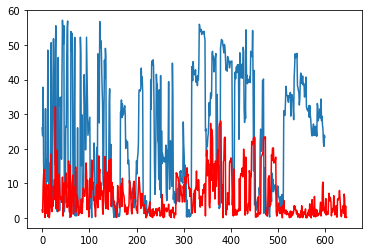

In [100]:
plt.plot(train_data_drowsy["degree"])
plt.plot(train_data_notdrowsy["degree"], color='red')
plt.show()

#### plot으로 찍어보기(diff X, diff Y)

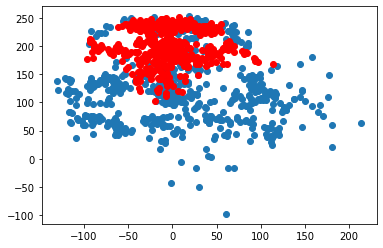

In [105]:
plt.scatter(train_data_drowsy["Diff_X"], train_data_drowsy["Diff_Y"])
plt.scatter(train_data_notdrowsy["Diff_X"], train_data_notdrowsy["Diff_Y"], color='red')
plt.show()

####  csv로 저장
* 필요없는 데이터는 삭제
* 일단 목, 코, 어깨 좌표 삭제
* 필요하다면 좌표들을 normalize하여서 사용해도 괜찮을듯?

In [106]:
train_data_drowsy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592 entries, 0 to 599
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   degree        592 non-null    float64
 1   Neck_X        592 non-null    float64
 2   Neck_Y        592 non-null    float64
 3   Nose_X        592 non-null    float64
 4   Nose_Y        592 non-null    float64
 5   R_Shoulder_X  592 non-null    float64
 6   R_Shoulder_Y  592 non-null    float64
 7   L_Shoulder_X  592 non-null    float64
 8   L_Shoulder_Y  592 non-null    float64
 9   label         592 non-null    int64  
 10  Diff_X        592 non-null    float64
 11  Diff_Y        592 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 60.1 KB


In [107]:
train_data_notdrowsy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645 entries, 0 to 645
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   degree        645 non-null    float64
 1   Neck_X        645 non-null    float64
 2   Neck_Y        645 non-null    float64
 3   Nose_X        645 non-null    float64
 4   Nose_Y        645 non-null    float64
 5   R_Shoulder_X  645 non-null    float64
 6   R_Shoulder_Y  645 non-null    float64
 7   L_Shoulder_X  645 non-null    float64
 8   L_Shoulder_Y  645 non-null    float64
 9   label         645 non-null    int64  
 10  Diff_X        645 non-null    float64
 11  Diff_Y        645 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 65.5 KB


In [108]:
train_data_drowsy = train_data_drowsy.drop(train_data_drowsy.columns[[1,2,3,4,5,6,7,8]], axis = 1)
train_data_notdrowsy = train_data_notdrowsy.drop(train_data_notdrowsy.columns[[1,2,3,4,5,6,7,8]], axis = 1)

In [109]:
train_data_drowsy = train_data_drowsy[['degree', 'Diff_X', 'Diff_Y', 'label']]
train_data_notdrowsy = train_data_notdrowsy[['degree', 'Diff_X', 'Diff_Y', 'label']]

In [110]:
train_data_drowsy

,degree,Diff_X,Diff_Y,label
0,26.054119,-59.344940,116.232319,1
1,23.757774,56.958437,124.999123,1
2,37.782328,61.280794,69.862318,1
3,15.870625,-39.689550,137.679749,1
4,10.653583,37.966919,200.628147,1
...,...,...,...,...
595,25.777300,-66.584673,132.175097,1
596,21.991573,-54.791183,131.816440,1
597,20.702839,-48.439322,125.000067,1
598,23.934946,-60.127144,130.772595,1


In [111]:
train_data_notdrowsy

,degree,Diff_X,Diff_Y,label
0,2.326522,-6.180687,152.087603,0
1,1.562390,-3.981304,145.947647,0
2,9.045893,-25.669956,160.551739,0
3,12.447431,-33.793869,151.838665,0
4,13.976415,-37.156544,147.720451,0
...,...,...,...,...
641,5.622362,-20.578928,208.701453,0
642,0.120880,0.420895,199.499416,0
643,3.458771,12.508659,206.832533,0
644,0.571113,2.089586,209.623003,0


In [112]:
DataSet = pd.concat([train_data_drowsy, train_data_notdrowsy], ignore_index= True)

In [113]:
DataSet

,degree,Diff_X,Diff_Y,label
0,26.054119,-59.344940,116.232319,1
1,23.757774,56.958437,124.999123,1
2,37.782328,61.280794,69.862318,1
3,15.870625,-39.689550,137.679749,1
4,10.653583,37.966919,200.628147,1
...,...,...,...,...
1232,5.622362,-20.578928,208.701453,0
1233,0.120880,0.420895,199.499416,0
1234,3.458771,12.508659,206.832533,0
1235,0.571113,2.089586,209.623003,0


In [114]:
DataSet.to_csv("data/train_data.csv", index = False)

In [115]:
test = pd.read_csv("data/train_data.csv")

In [116]:
test

,degree,Diff_X,Diff_Y,label
0,26.054119,-59.344940,116.232319,1
1,23.757774,56.958437,124.999123,1
2,37.782328,61.280794,69.862318,1
3,15.870625,-39.689550,137.679749,1
4,10.653583,37.966919,200.628147,1
...,...,...,...,...
1232,5.622362,-20.578928,208.701453,0
1233,0.120880,0.420895,199.499416,0
1234,3.458771,12.508659,206.832533,0
1235,0.571113,2.089586,209.623003,0
